In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("bitaksi_RFM_Segmentasyonu_Dummy_Data_1000.xlsx")
df.head()

,Customer ID,Last Transaction Date,Frequency (Usage in Last 12 Months),Total Spending (TL)
0,1,2024-04-25,50,1748
1,2,2024-09-19,37,4055
2,3,2024-04-10,39,2647
3,4,2024-04-23,6,3980
4,5,2024-07-30,4,2907


# Assign RFM Scores

### Recency (R) : Segment customers into 5 groups based on the number of days since their last ride.

In [3]:
import datetime as dt

In [4]:
# calculate recency

today = dt.datetime(2024, 12, 31) # assume today is the last day of 2024
df['Last Transaction Date'] = pd.to_datetime(df['Last Transaction Date'])
df['Recency'] = (today - df['Last Transaction Date']).dt.days

df['Recency'].head()

0    250
1    103
2    265
3    252
4    154
Name: Recency, dtype: int64

In [5]:
# sorting the 'Recency' column

df.sort_values(by='Recency', ascending=False).head(10)

print(df.sort_values(by='Recency', ascending=False).head(10).to_string(index=False))


 Customer ID Last Transaction Date  Frequency (Usage in Last 12 Months)  Total Spending (TL)  Recency
         871            2023-12-11                                   24                 2420      386
         222            2023-12-11                                   41                 1093      386
         885            2023-12-11                                   31                 2077      386
         475            2023-12-12                                   42                 2346      385
         170            2023-12-13                                    4                 1732      384
         273            2023-12-13                                   14                 1860      384
         540            2023-12-14                                   21                  887      383
          29            2023-12-14                                   19                 2275      383
         354            2023-12-14                                   18           

#### Recency thresholds (days since last ride) will be as below:

Score 5:   0 –  83 days

Score 4:  84 – 130 days

Score 3: 131 – 209 days

Score 2: 210 – 330 days

Score 1: 331 – 551 days



In [6]:
# Recency (R) : Segment customers into 5 groups based on the number of days since their last ride.

df['R_Score'] = pd.qcut(df['Recency'], q=5, labels=[5, 4, 3, 2, 1])

df[['Customer ID', 'Recency', 'R_Score']].head()

df_sorted_oldest = df.sort_values('Recency', ascending=False)

print(df_sorted_oldest[['Customer ID', 'Recency', 'R_Score']].head().to_string(index=False))

 Customer ID  Recency R_Score
         871      386       1
         222      386       1
         885      386       1
         475      385       1
         170      384       1


### Frequency (F) : Segment customers into 5 groups based on their total ride frequency.

In [7]:
df['F_Score'] = pd.qcut(df['Frequency (Usage in Last 12 Months)'], 5, labels=[1, 2, 3, 4, 5])

df[['Customer ID', 'Frequency (Usage in Last 12 Months)', 'F_Score']].head()        # preview
df['F_Score'].value_counts().sort_index()               # counts per score


F_Score
1    215
2    198
3    194
4    212
5    181
Name: count, dtype: int64

#### Frequency thresholds:

Score 5: 42 – 50 rides

Score 4: 32 – 41 rides

Score 3: 23 – 31 rides

Score 2: 12 – 22 rides

Score 1: 1 – 11 rides



In [8]:
# Show min, max, and customer count for each F_Score bucket

df.groupby('F_Score')['Frequency (Usage in Last 12 Months)'].agg(['min', 'max', 'count']).sort_index()

/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/3888657401.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('F_Score')['Frequency (Usage in Last 12 Months)'].agg(['min', 'max', 'count']).sort_index()


,min,max,count
F_Score,,,
1,1,11,215
2,12,22,198
3,23,31,194
4,32,41,212
5,42,50,181


### Monetary (M) : Segment customers into 5 groups based on their total spending. Higher values indicate higher scores.

In [9]:
df['M_Score'] = pd.qcut(df['Total Spending (TL)'], 5, labels=[1, 2, 3, 4, 5])

df[['Customer ID', 'Total Spending (TL)', 'M_Score']].head()      # preview
df['M_Score'].value_counts().sort_index() 

M_Score
1    200
2    200
3    200
4    200
5    200
Name: count, dtype: int64

In [10]:
df.groupby('M_Score')['Total Spending (TL)'] \
  .agg(['min', 'max', 'count']) \
  .sort_index()

/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/240070586.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('M_Score')['Total Spending (TL)'] \


,min,max,count
M_Score,,,
1,55,1132,200
2,1135,2077,200
3,2082,3117,200
4,3123,4048,200
5,4050,4991,200


# Analyze the Segments

## Identify the most valuable segments.

In [11]:
# Combine the scores into 3-digit RFM code. Customers who score '555' will be the best customers.

df['RFM_Score'] = (
    df['R_Score'].astype(str) +
    df['F_Score'].astype(str) +
    df['M_Score'].astype(str)
)

df['RFM_Score'].head()

0    252
1    445
2    243
3    214
4    413
Name: RFM_Score, dtype: object

### Customers who scored 5 in all three segments will show '555'. Let's call them 'champions'. Those who have any two 5's and one 4 will be 'loyal_big_spenders'. Lastly, those whose all digits are ≥4 will be named 'high_value_cluster'.

In [12]:
# Champions
champions = df[df['RFM_Score'] == '555']

# Loyal Big-Spenders (any two 5’s, one 4)
loyal_big_spenders = df[df['RFM_Score'].isin(['554','545','455','544'])]

# High-Value Loyalists (all digits ≥4)
high_value_cluster = df[df['RFM_Score'].str.match(r'^[45][45][45]$')]


In [13]:
cols = ['Customer ID', 'Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)', 'RFM_Score']
champions[cols].head(10)

,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
130,131,77,49,4166,555
249,250,83,46,4947,555
460,461,48,47,4144,555
553,554,73,47,4590,555
754,755,45,42,4373,555
830,831,35,44,4741,555


In [14]:
segments = [
    champions.assign(Segment='Champions'),
    loyal_big_spenders.assign(Segment='Loyal Big-Spenders'),
    high_value_cluster.assign(Segment='High-Value Cluster')
]

combined = pd.concat(segments, ignore_index=True)

cols = ['Segment', 'Customer ID', 'Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)', 'RFM_Score']

combined[cols].head(30)


,Segment,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
0,Champions,131,77,49,4166,555
1,Champions,250,83,46,4947,555
2,Champions,461,48,47,4144,555
3,Champions,554,73,47,4590,555
4,Champions,755,45,42,4373,555
5,Champions,831,35,44,4741,555
6,Loyal Big-Spenders,23,92,49,3974,554
7,Loyal Big-Spenders,78,35,37,3772,544
8,Loyal Big-Spenders,108,37,50,3961,554
9,Loyal Big-Spenders,115,86,33,3709,544


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/2094826210.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/2094826210.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/2094826210.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/2094826210.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

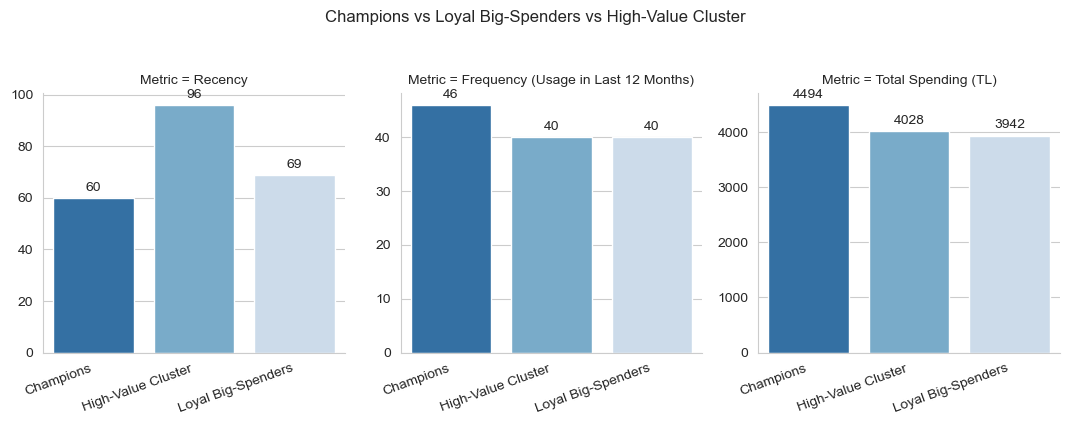

In [49]:
# plot

metrics = ['Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)']

seg_mean = (combined.groupby('Segment')[metrics]
            .mean()
            .round(0).astype(int)
            .reset_index()
            .melt(id_vars='Segment',
                  var_name='Metric', value_name='Mean'))

sns.set_style('whitegrid')

g = sns.catplot(
    data=seg_mean,
    x='Segment', y='Mean',
    col='Metric', kind='bar',
    palette='Blues_r',
    sharey=False, height=4, aspect=0.9
)

g.fig.suptitle('Champions vs Loyal Big-Spenders vs High-Value Cluster', y=1.05)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%d', padding=3)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


## Determine the characteristics of low-value segments.

### Criteria for low value segments will be that they are those whose overall RFM score is 222 or lower (e.g., 111, 122, 212).

In [214]:
low_value = df[
    (df['R_Score'].astype(int) <= 2) &   # not recent
    (df['F_Score'].astype(int) <= 2) &   # ride rarely
    (df['M_Score'].astype(int) <= 2)     # spend little
]

len(low_value)

65

In [215]:
low_value[['Customer ID',
           'Recency',
           'Frequency (Usage in Last 12 Months)',
           'Total Spending (TL)',
           'RFM_Score']].head()


,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
44,45,316,14,1176,222
56,57,271,12,782,221
74,75,325,21,929,121
105,106,355,15,1563,122
125,126,332,17,1018,121


In [216]:

low_stats = (
    low_value[['Recency',
               'Frequency (Usage in Last 12 Months)',
               'Total Spending (TL)']]
      .agg(['min', 'max', 'mean', 'count'])
      .round(0).astype(int)
      .T[['min', 'max', 'mean', 'count']]
)

print(low_stats)


                                     min   max  mean  count
Recency                              248   384   319     65
Frequency (Usage in Last 12 Months)    2    22    12     65
Total Spending (TL)                   55  2048  1042     65


### Characteristics of low-value segments:

- Recency for these users shows 8–13 months. 

- Frequency is between 2–22 (avg 1 ride/month).

- Lifetime spend per user is between ₺55 and ₺2 048 (mean = ₺1 042), well below core segments.

- In short, these customers were lightly engaged and have been dormant for nearly a year, making them ideal targets for a low-cost win-back or removal from expensive marketing lists.

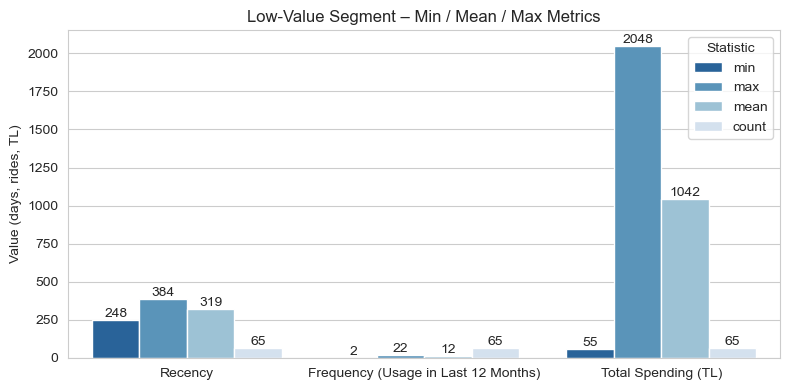

In [217]:
plot_df = (low_stats.reset_index()
                     .melt(id_vars='index',
                           var_name='Statistic',
                           value_name='Value')
                     .rename(columns={'index':'Metric'}))

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,4))

sns.barplot(data=plot_df,
            x='Metric', y='Value', hue='Statistic',
            order=['Recency',
                   'Frequency (Usage in Last 12 Months)',
                   'Total Spending (TL)'],
            palette='Blues_r', ax=ax)

ax.set_title('Low-Value Segment – Min / Mean / Max Metrics')
ax.set_ylabel('Value (days, rides, TL)')
ax.set_xlabel('')

for c in ax.containers:  # add numbers on bars
    ax.bar_label(c, fmt='%d')

plt.tight_layout()
plt.show()

## Highlight segments with growth potential.

### Segment #1 - "Potential Loyalists"

Those will be the customers who ride recently and fairly often but haven’t started spending big yet. Therefore, users whose R-score is 4-5 (recent), whose F-score is ≥ 3 (decent usage), and whose M-score is ≤ 3 (mid-/low spend) will be targeted. The idea here is to find people who have ridden recently, who ride fairly often, and to make them spend more than they usually do.

In [218]:
potential_loyalists = df[
    (df['R_Score'].astype(int) >= 4) &          
    (df['F_Score'].astype(int) >= 3) &         
    (df['M_Score'].astype(int) <= 3)            
]

cols = ['Customer ID', 'Recency',
        'Frequency (Usage in Last 12 Months)',
        'Total Spending (TL)', 'RFM_Score']
potential_loyalists[cols].head()  



,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
7,8,163,49,2407,453
14,15,61,43,1249,552
15,16,168,28,2429,433
16,17,142,32,394,441
17,18,161,39,2406,443


In [219]:
print("Potential Loyalists:", len(potential_loyalists))

Potential Loyalists: 134


### Why do Potential Loyalists matter?

- They’re active and forming a habit (high R, good F).

- Spending is still moderate (low M) → plenty of headroom for upsell.

- Timely incentives (loyalty points, ride bundles) can nudge them into the high-value “Loyal Big-Spender” tier.

### Segment #2 - "New Customers"

This segment includes those who are recent, ride rarely so far, and spend low.

In [220]:
new_customers = df[
    (df['R_Score'].astype(int) == 5) &
    (df['F_Score'].astype(int) <= 2) &
    (df['M_Score'].astype(int) <= 2)
]

cols = ['Customer ID', 'Recency',
        'Frequency (Usage in Last 12 Months)',
        'Total Spending (TL)', 'RFM_Score']
new_customers[cols].head()

,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
37,38,53,15,1957,522
43,44,32,20,873,521
61,62,36,15,1484,522
69,70,87,3,356,511
104,105,57,22,831,521


In [221]:
print("New Customers:", len(new_customers))

New Customers: 31


### Why do New Customers matter?

- Retention is cheapest now: a small welcome bonus can turn a one-off rider into a regular user.

- Early re-engagement multiplies lifetime value. Returning within the first month often increases eventual spend.

- A smooth first-ride experience locks in trust and referrals, reducing future acquisition costs.

### Segment #3 - "Promising"

These are the customers who have recently used the app and already taken a few rides, but whose spend is still relatively low.

In [222]:
promising = df[
    (df['R_Score'].astype(int) >= 4) & 
    (df['F_Score'].astype(int) <= 3) &  
    (df['M_Score'].astype(int) <= 2)
]

cols = ['Customer ID', 'Recency',
        'Frequency (Usage in Last 12 Months)',
        'Total Spending (TL)', 'RFM_Score']
promising[cols].head()

,Customer ID,Recency,Frequency (Usage in Last 12 Months),Total Spending (TL),RFM_Score
24,25,140,8,1705,412
37,38,53,15,1957,522
38,39,127,26,480,431
43,44,32,20,873,521
55,56,134,28,534,431


In [223]:
print("Promising:", len(promising))

Promising: 92


### Why do New Customers matter?

- Early habit signals – they’ve come back for a second or third ride, so adoption is under way.

- Low current spend – plenty of room to grow basket size with ride bundles or tiered loyalty perks.

- Easier lift than brand-new users – they already recognise the value proposition; we are nudging frequency and spend, not teaching the basics.

### Plot the Mean R_Score, F_Score, and M_Score, Segment by Segment:

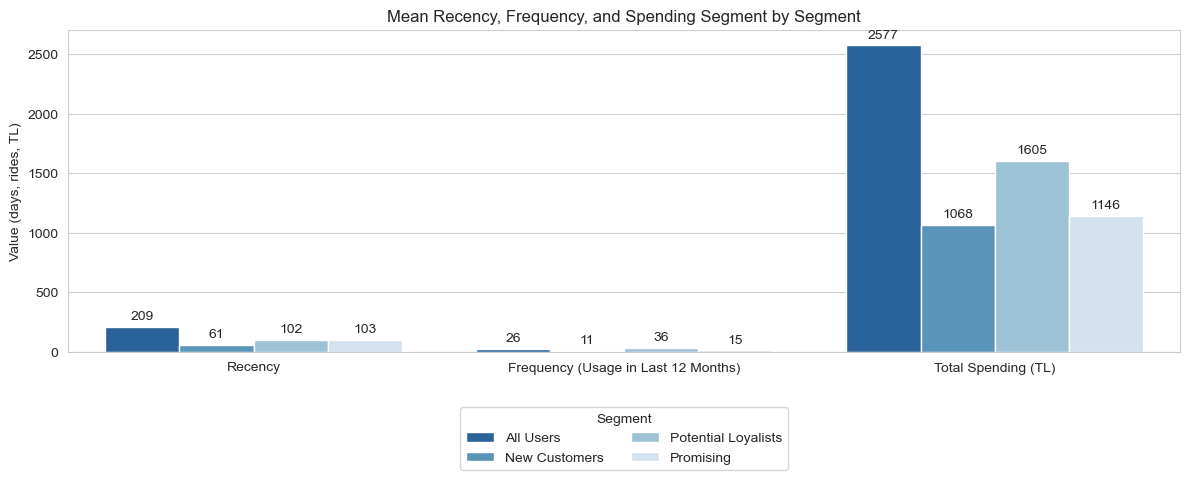

In [228]:
segments_df = pd.concat([
    df.assign(Segment='All Users'),
    promising.assign(Segment='Promising'),
    potential_loyalists.assign(Segment='Potential Loyalists'),
    new_customers.assign(Segment='New Customers')
])

metrics = ['Recency',
           'Frequency (Usage in Last 12 Months)',
           'Total Spending (TL)']

seg_means = (segments_df
             .groupby('Segment')[metrics]
             .mean()
             .round(0)
             .reset_index()
             .melt(id_vars='Segment',
                   var_name='Metric',
                   value_name='Mean'))

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 5))  

sns.barplot(data=seg_means,
            x='Metric', y='Mean', hue='Segment',
            palette='Blues_r', ax=ax)

ax.set_title('Mean Recency, Frequency, and Spending Segment by Segment')
ax.set_ylabel('Value (days, rides, TL)')
ax.set_xlabel('')

ax.legend(title='Segment',
          loc='upper center',
          bbox_to_anchor=(0.5, -0.15),      
          ncol=2)                          

# add value labels
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()


# Step 2: Data-Driven Insights

## 1. Which segment represents the most valuable customers? Why?

In order to decide which segment represents the most valuable customers, we first need to look at the top segments and compare them. While champions bring the most value per user, they are very few (6 people), and there are not many possibilities to upsell because they are already using the app to the maximum. Instead, if we shift our focus to loyal big spenders (27), we see that much of our revenue are already coming from them, and we have the potential to turn them into champions!

Let's compare these segments and understand why we should tag loyal big spenders as the most valuable customers.

In [25]:
# Champions = 555
champions = df[
    (df['R_Score'].astype(int) == 5) &
    (df['F_Score'].astype(int) == 5) &
    (df['M_Score'].astype(int) == 5)
]

# Loyal Big-Spenders = any two 5s + one 4
loyal_codes = ['554', '545', '544', '455']
loyal_big_spenders = df[df['RFM_Score'].isin(loyal_codes)]

# KPI comparison
summary = pd.DataFrame({
    'Metric': ['Customer count',
               'Total revenue (TL)',
               'Revenue per customer (TL)'],
    'Champions': [
        int(len(champions)),
        int(champions['Total Spending (TL)'].sum()),
        int(champions['Total Spending (TL)'].mean())
    ],
    'Loyal Big-Spenders': [
        int(len(loyal_big_spenders)),
        int(loyal_big_spenders['Total Spending (TL)'].sum()),
        int(loyal_big_spenders['Total Spending (TL)'].mean())
    ]
})

print(summary.to_string(index=False))



                   Metric  Champions  Loyal Big-Spenders
           Customer count          6                  27
       Total revenue (TL)      26961              106433
Revenue per customer (TL)       4493                3941


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/1675431350.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=plot_df,


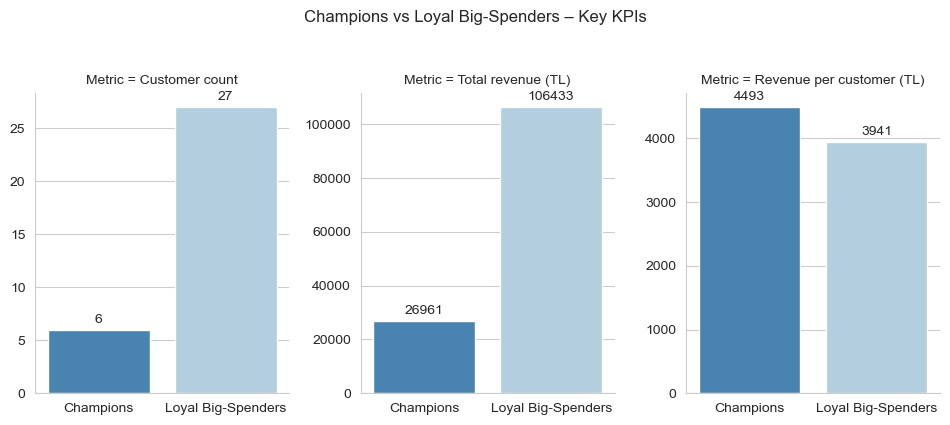

In [30]:
# plot 
plot_df = summary.melt(id_vars='Metric',
                       var_name='Segment',
                       value_name='Value')

g = sns.catplot(data=plot_df,
                x='Segment', y='Value',
                col='Metric', kind='bar',
                palette='Blues_r',
                sharey=False, height=4, aspect=0.8)

g.fig.suptitle('Champions vs Loyal Big-Spenders – Key KPIs', y=1.05)

for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f', padding=3)
    ax.set_xlabel('')           
    ax.set_ylabel('')           

plt.tight_layout()
plt.show()


As seen clearly in the graphs above, the difference between the revenue per customer between Champions and Loyal Big-Spenders is not that much, whereas the headcount of loyal big spenders quadruples that of champions. In addition, the total revenue the loyal big spenders bring is almost four times more than that of champions. Imagine if we can convert at least some of them to champions, that would be very profitable for the business.

## 2. Which segment requires immediate action to prevent churn?

Let's call this segment as "At-risk". Those are the users whose R_score is low (R ≤ 2) but who were formerly high-frequency or high-spend (F_score ≥ 4 or M_score ≥ 4). They used to be valuable but haven’t opened the app for months.

Why are they urgent? They’re slipping away with the largest potential revenue haircut because their historical spend/frequency is high. Winning them back is cheaper than replacing them with new acquisitions.



In [35]:
at_risk = df[
    (df['R_Score'].astype(int) <= 3) &        
    (
        (df['F_Score'].astype(int) >= 3) |    
        (df['M_Score'].astype(int) >= 3)      
    )
]

len(at_risk)          # count


497

Now, let's compare them to all other users.

In [36]:
others = df.drop(at_risk.index)

# KPI comparison
summary = pd.DataFrame({
    'Metric': ['Customer count', 'Total revenue (TL)', 'Revenue per customer (TL)'],
    'At-Risk': [
        int(len(at_risk)),
        int(at_risk['Total Spending (TL)'].sum()),
        int(at_risk['Total Spending (TL)'].mean())
    ],
    'All other users': [
        int(len(others)),
        int(others['Total Spending (TL)'].sum()),
        int(others['Total Spending (TL)'].mean())
    ]
})

print(summary.to_string(index=False))

                   Metric  At-Risk  All other users
           Customer count      497              503
       Total revenue (TL)  1418236          1159047
Revenue per customer (TL)     2853             2304


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/1755433812.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=plot_df,
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/1755433812.py:17: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


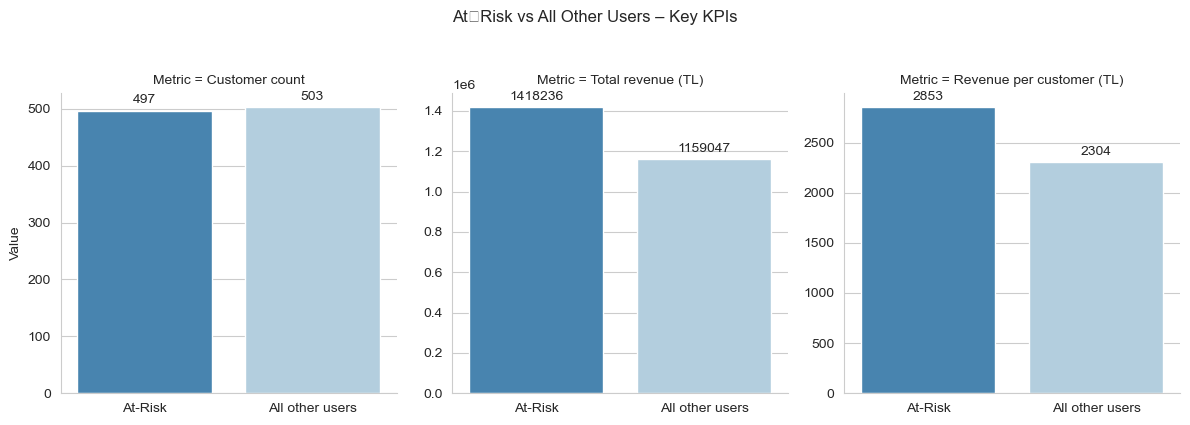

In [39]:
# plot

g = sns.catplot(data=plot_df,
                x='Segment', y='Value',
                col='Metric', kind='bar',
                palette='Blues_r',
                sharey=False, height=4, aspect=1)

g.fig.suptitle('At‑Risk vs All Other Users – Key KPIs', y=1.05)

# add value labels & clean axes
for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f', padding=3)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

As seen above, the at-risk segment is comprised of almost the half of the whole user dataset. In addition, they are bringing more revenue than the rest of the users combined. The red flag here is that these users are not seen for some time already - their R_Score is <= 3. We need immediate action to bring those customers back, or else we will lose a significant amount of revenue in the mid-long run. 

## 3. How does customer behavior differ across the segments in terms of Recency, Frequency, and Monetary metrics?

So far, we have segmented our dataset to 6: 

- Champions
- Loyal Big Spenders
- Poteantial Loyalists
- Promising
- New Customers
- At-risk

Let's plot all of them:


Mean metrics by segment:

Metric               Frequency (Usage in Last 12 Months)  Recency  Total Spending (TL)
Segment                                                                               
At-Risk                                             30.0    282.0               2853.6
Champions                                           45.8     60.2               4493.5
Loyal Big-Spenders                                  39.6     69.3               3942.0
New Customers                                       11.1     61.2               1067.6
Potential Loyalists                                 35.7    102.1               1604.8
Promising                                           19.3    137.5               1349.6


/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/1723379026.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/1723379026.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/1723379026.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
/var/folders/1z/j73pt9wx3dj89j3b5hd6qyhh0000gn/T/ipykernel_1080/1723379026.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

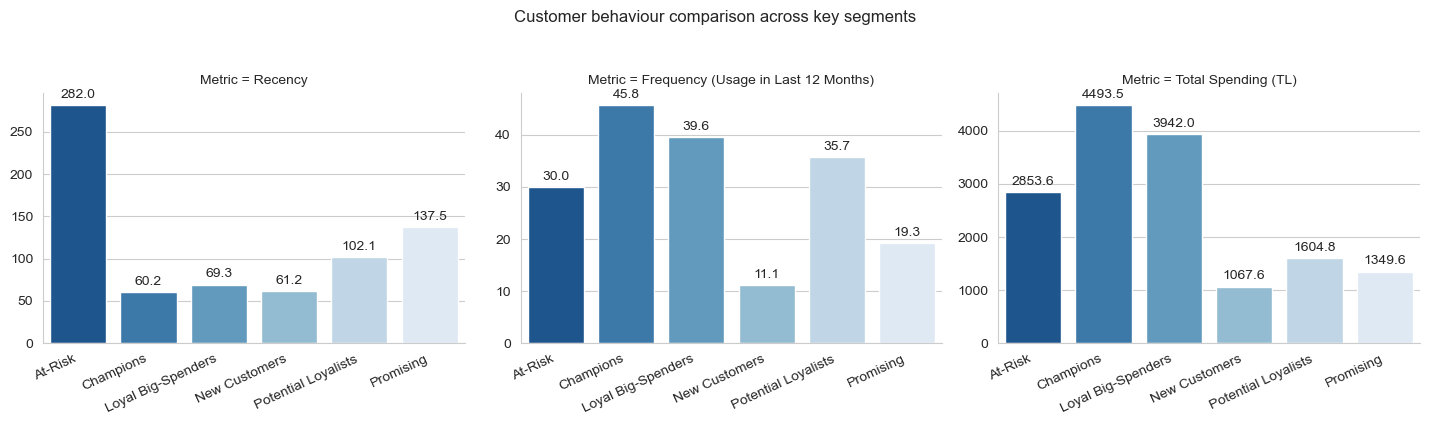

In [46]:
df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5,4,3,2,1])
df['F_Score'] = pd.qcut(df['Frequency (Usage in Last 12 Months)'], 5, labels=[1,2,3,4,5])
df['M_Score'] = pd.qcut(df['Total Spending (TL)'], 5, labels=[1,2,3,4,5])
df['RFM_Score'] = df['R_Score'].astype(str) + df['F_Score'].astype(str) + df['M_Score'].astype(str)

# ------- 2. Map rows to the requested segments ---------------------------
def label_segment(row):
    r = int(row['R_Score']); f = int(row['F_Score']); m = int(row['M_Score'])
    rfm = row['RFM_Score']
    
    if r == 5 and f == 5 and m == 5:
        return 'Champions'
    if rfm in ['554','545','544','455']:
        return 'Loyal Big-Spenders'
    if r == 5 and f <= 2 and m <= 2:
        return 'New Customers'
    if r >= 4 and f >= 3 and m <= 3:
        return 'Potential Loyalists'
    if r >= 4 and f == 2 and m <= 2:
        return 'Promising'
    if r <= 3 and ((f >= 3) or (m >= 3)):
        return 'At-Risk'
    return 'Others'

df['Segment'] = df.apply(label_segment, axis=1)

# keep only the six named segments
segments_of_interest = ['Champions','Loyal Big-Spenders','New Customers',
                        'Potential Loyalists','Promising','At-Risk']
seg_df = df[df['Segment'].isin(segments_of_interest)].copy()

# ------- 3. Aggregate mean metrics ---------------------------------------
metrics = ['Recency', 'Frequency (Usage in Last 12 Months)', 'Total Spending (TL)']
seg_mean = (seg_df.groupby('Segment')[metrics]
            .mean()
            .round(1)
            .reset_index()
            .melt(id_vars='Segment', var_name='Metric', value_name='Mean'))

# ------- 4. Table view ----------------------------------------------------
pivot_table = seg_mean.pivot(index='Segment', columns='Metric', values='Mean').round(1)
print("\nMean metrics by segment:\n")
print(pivot_table.to_string())

# ------- 5. Visual comparison --------------------------------------------

sns.set_style('whitegrid')

g = sns.catplot(
    data=seg_mean,
    x='Segment', y='Mean',
    col='Metric', kind='bar',
    palette='Blues_r',
    sharey=False,
    height=4, aspect=1.2     
)

g.fig.suptitle('Customer behaviour comparison across key segments', y=1.05)

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.1f', padding=3)
    
    ax.set_xlabel('')   
    ax.set_ylabel('')   

plt.tight_layout()
plt.show()


### Behaviour Differences Across Key Segments  

| Segment | Recency&nbsp;*(days since last ride)* | Frequency&nbsp;*(rides / yr)* | Monetary&nbsp;*(TL / yr)* | Take-away |
|---------|:------------------------------------:|:-----------------------------:|:-------------------------:|-----------|
| **Champions** | **60** | **46** | **4 494** | Ride very recently and very often, spend the most — top VIPs. |
| **Loyal Big-Spenders** | 69 | 40 | 3 942 | Almost as active as Champions and still high spend; biggest single revenue block. |
| **Potential Loyalists** | 102 | 36 | 1 605 | Active and fairly frequent but mid-range spend → prime upsell targets. |
| **Promising** | 138 | 19 | 1 350 | Recent but only a few rides so far; early-stage habit to nurture. |
| **New Customers** | 61 | 11 | 1 068 | Very recent sign-ups with low usage & spend — activation window is now. |
| **At-Risk** | **282** | 30 | 2 854 | Historically valuable but inactive for 9 months; urgent win-back needed. |

**Key contrasts**

* **Recency:** Champions, Loyal Big-Spenders, and New Customers are all seen within the last 2 months, whereas At-Risk users haven’t opened the app for 9 months.
* **Frequency:** Champions ride the most (4 rides/month). Promising and New Customers are still below 2 rides/month.
* **Monetary:** Spend per rider drops sharply after Loyal Big-Spenders; Potential Loyalists and Promising have head-room to grow, while At-Risk still carry high historic spend despite long dormancy.

These averages highlight where to **retain (Champions, Loyal Big-Spenders), nurture (Potential Loyalists, Promising), activate (New Customers), and rescue (At-Risk)**.
